### Setup

In [53]:
!pip uninstall requests --yes
!pip install requests==2.27.1
import requests
print(requests.__version__)

Found existing installation: requests 2.27.1
Uninstalling requests-2.27.1:
  Successfully uninstalled requests-2.27.1
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.18.0 requires jsonschema>=4.17.3, but you have jsonschema 3.2.0 which is incompatible.
jupyterlab-server 2.18.0 requires requests>=2.28, but you have requests 2.27.1 which is incompatible.
2.27.1


In [54]:
!pip install albumentations
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
/bin/sh: apt: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [55]:
# Setting folder path
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'

/home/ec2-user/SageMaker/dl-ecommerce-duplicates


In [56]:
import math
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visuals and CV2
import cv2

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold, train_test_split

#torch
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, lr_scheduler

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from sklearn.model_selection import GroupKFold
from modules.datasets.TextArcFaceLossShopeeDataset import TextArcFaceLossShopeeDataset
from modules.datasets.TextShopeeDataset import TextShopeeDataset
from modules.models.BertWithArcFace import BertWithArcFace
from modules.models.PreTrainedEmbeddingsText import PreTrainedEmbeddingsText
from modules.utils.training_utils import train_fn,valid_fn
import faiss
import gc
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.CommonVIsualizer import CommonVisualizer
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
os.environ['CURL_CA_BUNDLE'] = ''
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
import ssl
import urllib3
ssl._create_default_https_context = ssl._create_unverified_context
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [57]:
def read_dataset(file):
    df = pd.read_csv(file)
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['target'] = df['label_group'].map(tmp)
    df['target'] = df['target'].apply(lambda x: ' '.join(x))
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    df['target'] = df['label_group'].map(grouped)
    return df

In [58]:
#Training Data Set
file = '../shopee-product-matching/train80.csv'
train_df = read_dataset(file)
train_df['label_group'] = LabelEncoder().fit_transform(train_df['label_group'])

#Validation Dataset
file = '../shopee-product-matching/valid20.csv'
valid_df = read_dataset(file)
valid_df['label_group'] = LabelEncoder().fit_transform(valid_df['label_group'])

#Full Dataset
file = '../shopee-product-matching/train.csv'
full_df = read_dataset(file)
full_df['label_group'] = LabelEncoder().fit_transform(full_df['label_group'])

In [59]:
#Params
thresholds = np.arange(0.4, 0.99, 0.05)

# TFIDF

In [60]:

model = TfidfVectorizer(stop_words=None, binary=True, max_features=5000)
text_embeddings = model.fit_transform(train_df.title).toarray().astype(np.float32)
print('text embeddings shape',text_embeddings.shape)

text embeddings shape (27399, 5000)


## F1-Score on Train DF

100%|██████████| 12/12 [01:38<00:00,  8.20s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


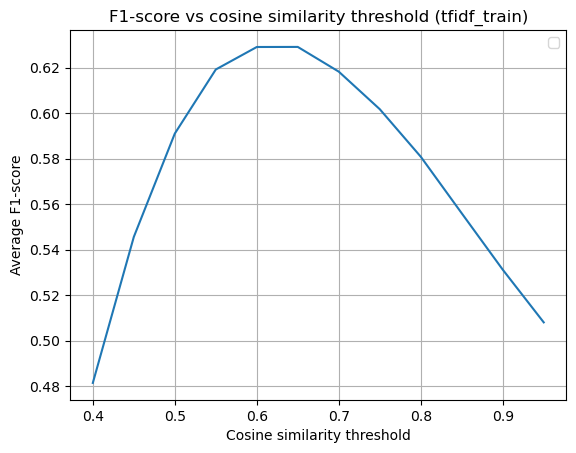

Max_F1_Score 0.6291740915771965


In [61]:
model_name = 'tfidf'
f1_avg_scores = F1ScoreEvaluator(train_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name + '_train_f1_scores') 
model_name_and_loss = model_name + "_train"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

## F1-Score on Valid DF

100%|██████████| 12/12 [00:24<00:00,  2.04s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


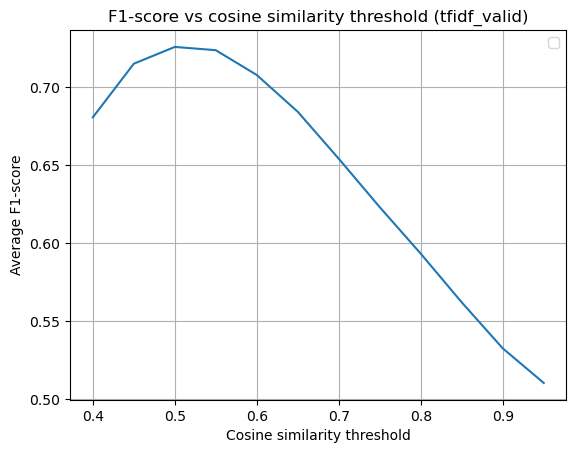

Max_F1_Score 0.7255763531902748


In [62]:
text_embeddings = model.transform(valid_df.title).toarray().astype(np.float32)
f1_avg_scores = F1ScoreEvaluator(valid_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name + '_valid_f1_scores') 
model_name_and_loss = model_name + "_valid"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

## F1-Score on Full DF

100%|██████████| 12/12 [02:02<00:00, 10.20s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


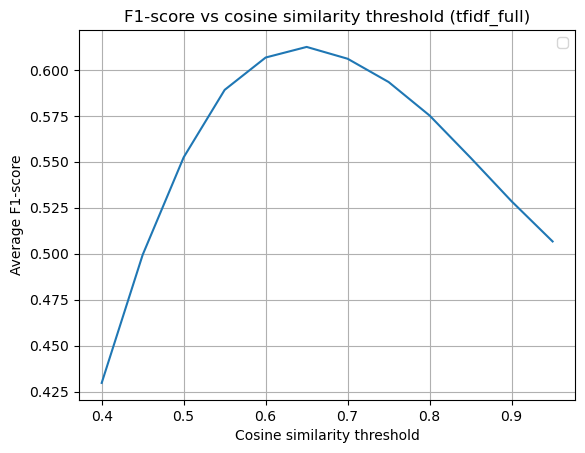

Max_F1_Score 0.6124666626673826


In [63]:
text_embeddings = model.transform(full_df.title).toarray().astype(np.float32)
f1_avg_scores = F1ScoreEvaluator(full_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name + '_full_f1_scores') 
model_name_and_loss = model_name + "_full"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

# BERT Baseline

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
model_name = "bert-base-uncased"
train_dataset = TextShopeeDataset(train_df['title'].values)
valid_dataset = TextShopeeDataset(valid_df['title'].values)
full_dataset = TextShopeeDataset(full_df['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

### F1 Scores on Training Set

In [47]:
bert_pretrain_model = PreTrainedEmbeddingsText(model_name)
bert_pretrain_model.to(device)
text_embeddings = []

with torch.no_grad():
    for data in tqdm(train_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

100%|██████████| 429/429 [01:29<00:00,  4.77it/s]


100%|██████████| 12/12 [02:07<00:00, 10.66s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


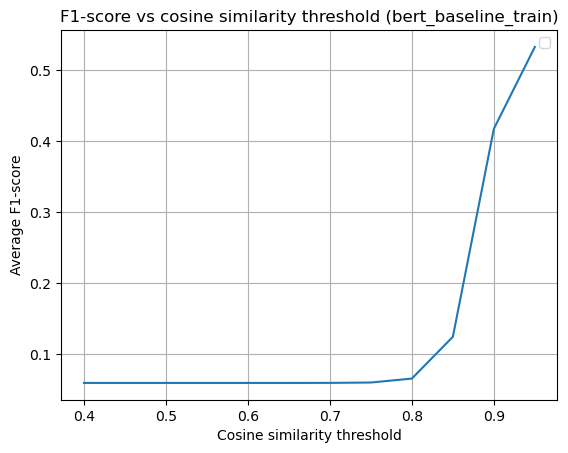

Max_F1_Score 0.532541651452821


In [48]:
model_name_val = 'bert_baseline'
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(train_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_train_f1_scores') 
model_name_and_loss = model_name_val + "_train"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

### F1 Scores on Valid Set

In [49]:
text_embeddings = []
with torch.no_grad():
    for data in tqdm(valid_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

100%|██████████| 108/108 [00:18<00:00,  5.70it/s]


100%|██████████| 12/12 [00:29<00:00,  2.48s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


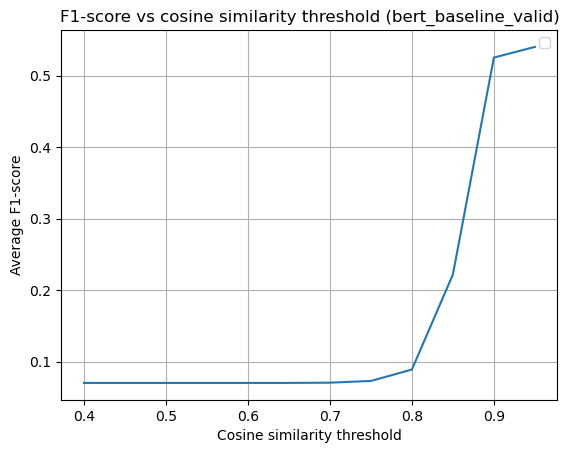

Max_F1_Score 0.5399753303127297


In [50]:
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(valid_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_valid_f1_scores')
model_name_and_loss = model_name_val + "_valid"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

### F1 Scores on Full Dataset

In [51]:
text_embeddings = []
with torch.no_grad():
    for data in tqdm(full_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

100%|██████████| 536/536 [01:43<00:00,  5.19it/s]


100%|██████████| 12/12 [02:49<00:00, 14.17s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


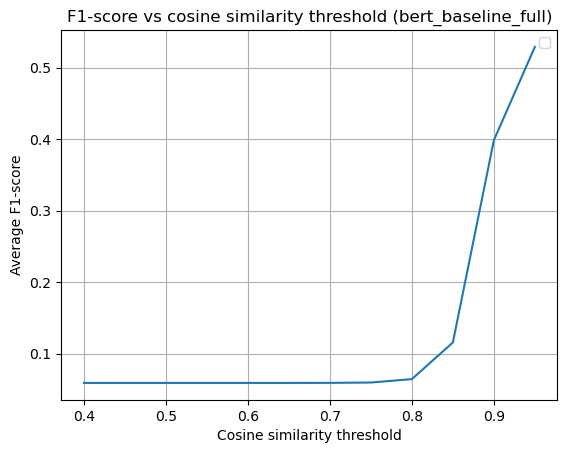

Max_F1_Score 0.5291314269362297


In [52]:
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(full_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_full_f1_scores') 
model_name_and_loss = model_name_val + "_full"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

# XLM Baseline Model

In [27]:
model_name = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
train_dataset = TextShopeeDataset(train_df['title'].values)
valid_dataset = TextShopeeDataset(valid_df['title'].values)
full_dataset = TextShopeeDataset(full_df['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

### XLM Training F1 Scores

In [29]:
bert_pretrain_model = PreTrainedEmbeddingsText(model_name)
bert_pretrain_model.to(device)
text_embeddings = []

with torch.no_grad():
    for data in tqdm(train_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

100%|██████████| 429/429 [01:46<00:00,  4.02it/s]


100%|██████████| 12/12 [01:53<00:00,  9.42s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


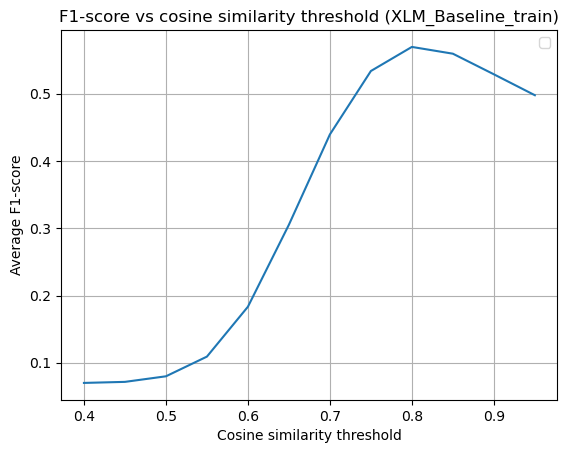

Max_F1_Score 0.5696575295071643


In [39]:
model_name_val = 'XLM_Baseline'
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(train_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_train_f1_scores') 
model_name_and_loss = model_name_val + "_train"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

### F1 Scores on Valid Dataset

In [40]:
text_embeddings = []
with torch.no_grad():
    for data in tqdm(valid_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

100%|██████████| 108/108 [00:30<00:00,  3.57it/s]


100%|██████████| 12/12 [00:26<00:00,  2.21s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


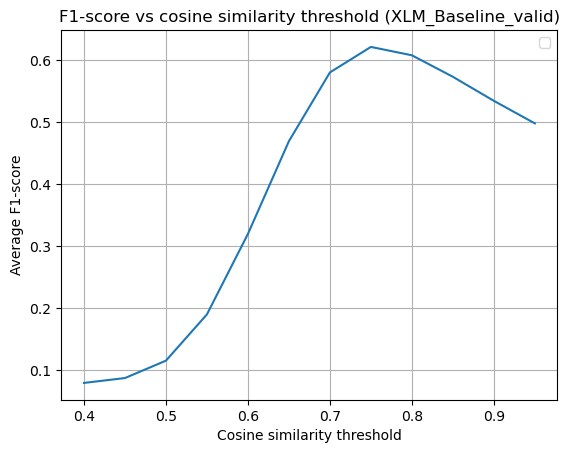

Max_F1_Score 0.6214893385976884


In [41]:
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(valid_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_valid_f1_scores')
model_name_and_loss = model_name_val + "_valid"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))

### F1 Scores on Full Dataset

In [43]:
text_embeddings = []
with torch.no_grad():
    for data in tqdm(full_loader):
        data.to(device)
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)
text_embeddings = np.array(text_embeddings)

100%|██████████| 536/536 [02:16<00:00,  3.92it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


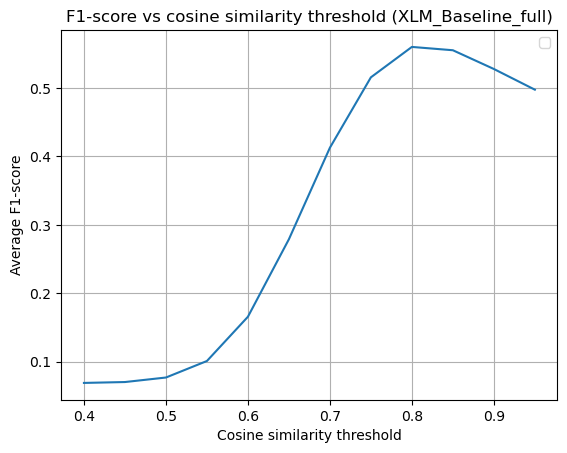

Max_F1_Score 0.5600699174756809


In [45]:
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(full_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_full_f1_scores') 
model_name_and_loss = model_name_val + "_full"
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_and_loss,filename = filename)
print("Max_F1_Score",np.max(f1_avg_scores))